# Label Analysis

In this notebook we analyse the datsets and label distributions we get for different settings for sampling and labeling strategy.

In [1]:
%reload_ext autoreload
%autoreload 2
import re
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datasets import HighQualityFallDataset
from datasets.transforms.label_strategy import HQFD_LABEL_DESCRIPTION, PriorityLabel
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling

In [2]:
from mmaction.datasets.transforms import (
    DecordInit,
    DecordDecode,
    SampleFrames,
    Resize,
    RandomCrop,
    Flip,
    FormatShape,
    PackActionInputs,
    CenterCrop,
)
from datasets.transforms import ClipVideo

# Train pipeline
train_pipeline = [
    DecordInit(),
    ClipVideo(),
    SampleFrames(clip_len=16, frame_interval=8, num_clips=1),
    DecordDecode(),
    Resize(scale=(-1, 224)),
    RandomCrop(size=224),
    Resize(scale=(224, 224), keep_ratio=False),
    Flip(flip_ratio=0.5),
    FormatShape(input_format="NCTHW"),
    PackActionInputs(),
]

val_pipeline = [
    DecordInit(),
    ClipVideo(),
    SampleFrames(clip_len=16, frame_interval=8, num_clips=1, test_mode=True),
    DecordDecode(),
    Resize(scale=(-1, 224)),
    CenterCrop(crop_size=224),
    FormatShape(input_format="NCTHW"),
    PackActionInputs(),
]

In [3]:
val_ann_file = "data/Fall_Simulation_Data/annotations_val.csv"
train_ann_file = "data/Fall_Simulation_Data/annotations_train.csv"

np.random.seed(42)

gaussian_sampling = GaussianSampling(
    clip_len=5,
    n_samples_per_sec=None,
    fallback_sampler=UniformSampling(clip_len=5, stride=5, overlap=False),
    std=None,
)
label_strategy = PriorityLabel(
    label_description=HQFD_LABEL_DESCRIPTION,
    threshold=0,
    absolute_threshold=False,
    priority=[0, 1, 2],
)

uniform_sampling = UniformSampling(clip_len=5, stride=0, overlap=False)
val_hqfd = HighQualityFallDataset(
    ann_file=val_ann_file,
    sampling_strategy=uniform_sampling,
    label_strategy=label_strategy,
    pipeline=val_pipeline,
    num_classes=3,
    test_mode=True,
)

train_hqfd = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=gaussian_sampling,
    label_strategy=label_strategy,
    pipeline=train_pipeline,
    num_classes=3,
    test_mode=False,
    drop_ratios=[0.0, 0.0, 0.30],
)

In [4]:
def analyse_dataset(ds):
    df_hqfd = convert_ds_to_df(ds)
    display("------- Full Dataset -------")
    plot_label_dist(df_hqfd)
    display("------- Only Fall videos -------")
    plot_label_dist(df_hqfd[df_hqfd["video_category"] == "Fall"])


def convert_ds_to_df(ds: HighQualityFallDataset):
    np.random.seed(42)
    df_hqfd = pd.DataFrame(ds.load_data_list())
    class_names = ["Fall", "Lying", "Other"]
    df_hqfd["label_name"] = df_hqfd["label"].apply(lambda x: class_names[x])

    def extract_category(filename):
        match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
        return match.group(1) if match else None

    df_hqfd["video_category"] = df_hqfd["filename"].apply(extract_category)

    return df_hqfd


def plot_label_dist(df_hqfd):
    display("---- Dataset Size ----")
    display(len(df_hqfd))

    display("---- Label Distribution ----")
    display(df_hqfd["label_name"].value_counts().sort_index() / len(df_hqfd))

    display("---- Label Counts ----")
    display(df_hqfd["label_name"].value_counts().sort_index())
    df_hqfd["label_name"].value_counts().sort_index().plot(kind="bar")
    plt.show()

## Train DS

'------- Full Dataset -------'

'---- Dataset Size ----'

10876

'---- Label Distribution ----'

label_name
Fall     0.146837
Lying    0.194189
Other    0.658974
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall     1597
Lying    2112
Other    7167
Name: count, dtype: int64

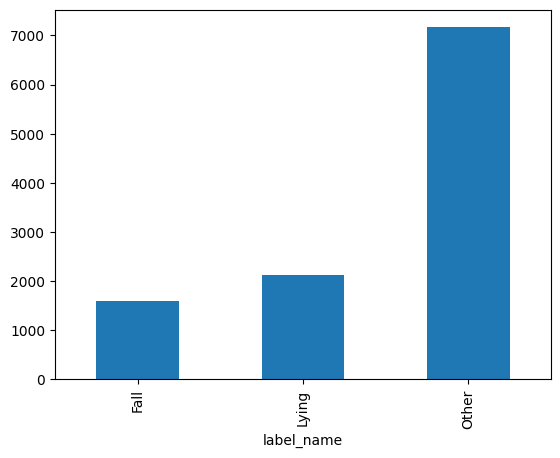

'------- Only Fall videos -------'

'---- Dataset Size ----'

5532

'---- Label Distribution ----'

label_name
Fall     0.288684
Lying    0.381779
Other    0.329537
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall     1597
Lying    2112
Other    1823
Name: count, dtype: int64

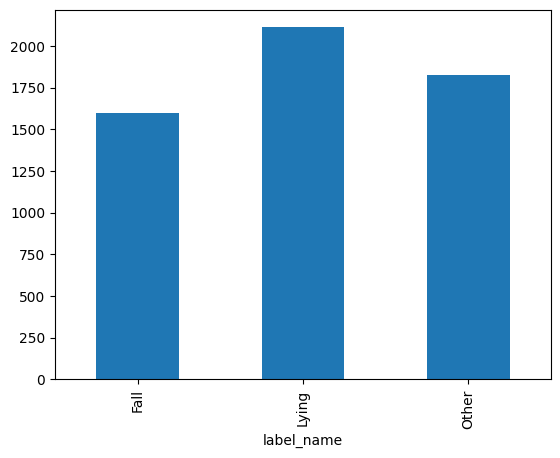

In [5]:
analyse_dataset(train_hqfd)

## Val DS

'------- Full Dataset -------'

'---- Dataset Size ----'

2985

'---- Label Distribution ----'

label_name
Fall     0.013400
Lying    0.157789
Other    0.828811
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall       40
Lying     471
Other    2474
Name: count, dtype: int64

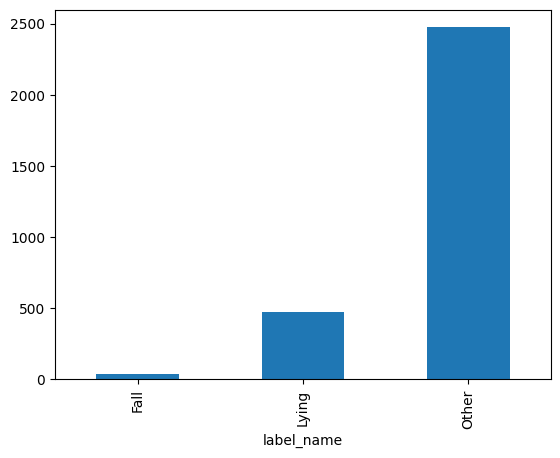

'------- Only Fall videos -------'

'---- Dataset Size ----'

852

'---- Label Distribution ----'

label_name
Fall     0.046948
Lying    0.552817
Other    0.400235
Name: count, dtype: float64

'---- Label Counts ----'

label_name
Fall      40
Lying    471
Other    341
Name: count, dtype: int64

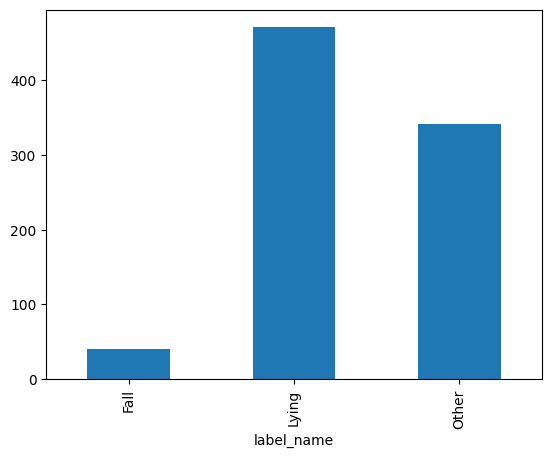

In [6]:
analyse_dataset(val_hqfd)

# Visualization of Samples

In [9]:
from mmaction.visualization import ActionVisualizer

vis = ActionVisualizer()


def get_random_sample_from_class(ds: HighQualityFallDataset, label: int, n: int = 1):
    np.random.seed(42)
    dl = pd.DataFrame(ds.load_data_list())
    idx = dl[dl["label"] == label].index.to_list()
    idx = np.random.choice(idx, size=n, replace=False)
    return idx


def render_sample_videos(path: str = "tmp"):
    from ipywidgets import Output, GridspecLayout
    from IPython import display

    videos = sorted(Path(path).glob("*.gif"))
    grid = GridspecLayout((len(videos) // 4) + 1, 4)

    for i, video in enumerate(videos):
        out = Output()
        with out:
            display.display(display.Image(video))
        grid[i // 4, i % 4] = out

    display.display(grid)


def generate_sample_videos(
    ds: HighQualityFallDataset,
    idx: int | list[int],
    out_path: str | None = None,
    render: bool = True,
):
    if isinstance(idx, int):
        idx = [idx]
    vis = ActionVisualizer()
    for i in idx:
        # video [B, C, T, H, W] -> [T, H, W, C]
        video = ds[i]["inputs"].squeeze(0).permute(1, 2, 3, 0).numpy().astype(np.uint8)
        # Convert to RGB
        video = video[..., ::-1]
        vis.add_datasample(
            name=i,
            video=video,
            data_sample=ds[i]["data_samples"],
            draw_gt=True,
            show_frames=True,
            out_type="gif",
            out_path=f"tmp/{i}.gif" if out_path is None else out_path + f"/{i}.gif",
        )
    if render:
        render_sample_videos()
        shutil.rmtree("tmp")

## Validation Vis

### Class 0 Samples in Val

In [43]:
idx = get_random_sample_from_class(val_hqfd, 0, 20)
generate_sample_videos(val_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### Class 1 Val Samples

In [44]:
idx = get_random_sample_from_class(val_hqfd, 1, 20)
generate_sample_videos(val_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### Class 2 Val

In [45]:
idx = get_random_sample_from_class(val_hqfd, 2, 20)
generate_sample_videos(val_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

## Train Vis

In [10]:
idx = get_random_sample_from_class(train_hqfd, 0, 20)
generate_sample_videos(train_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [11]:
idx = get_random_sample_from_class(train_hqfd, 1, 20)
generate_sample_videos(train_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [12]:
idx = get_random_sample_from_class(train_hqfd, 2, 20)
generate_sample_videos(train_hqfd, idx)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

# Class weight calculation

weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

In [49]:
weights = []
num_classes = 3
for i in range(num_classes):
    total_samples = len(df_hqfd)
    num_samples_in_class_i = len(df_hqfd[df_hqfd["label"] == i])
    weights.append(total_samples / num_samples_in_class_i * num_classes)

display(weights)

NameError: name 'df_hqfd' is not defined